In [1]:
#!pip3 install opencv-python
# this is a bug fix, on advice from mentor Ayush
# NO LONGER REQUIRED IN WORKSPACE? (maybe support have fixed this permanently)

# 1 Camera Calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt

# prepare object points
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
#print(objp) yields
#[[ 0.  0.  0.]
# [ 1.  0.  0.]
# [ 2.  0.  0.]
# [ 3.  0.  0.]
# ...

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')
#print(type(images))  images is a pyton list

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'corners_found/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #plt.imshow(img) #cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()



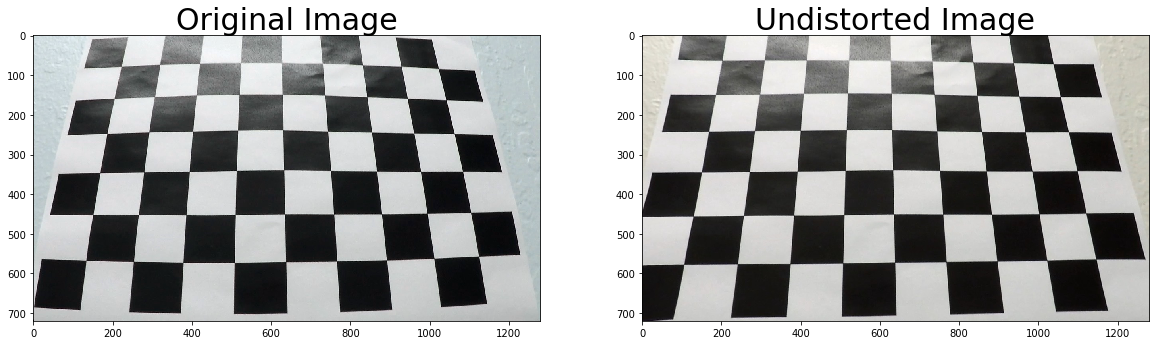

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/calibration3_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
#cv2.imwrite('./camera_cal/calibration3_compare.jpg',f)

# 2 Pipeline single images

## 2.1 Provide an example of a distortion-corrected image.

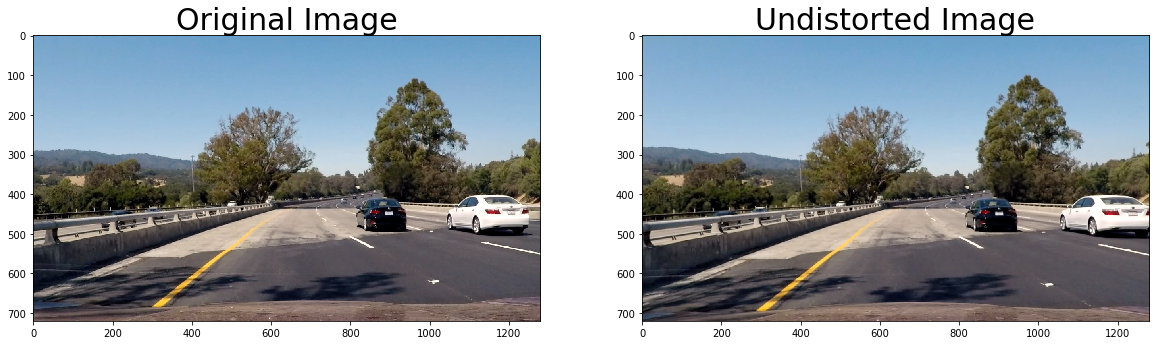

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

#reading in an image
#image = mpimg.imread('test_images/test1.jpg')
#image = mpimg.imread('test_images/test2.jpg')
#image = mpimg.imread('test_images/test3.jpg')
image = mpimg.imread('test_images/test4.jpg') # difficult one
#image = mpimg.imread('test_images/test5.jpg') # curvature uneven 
#image = mpimg.imread('test_images/test6.jpg')
#image = mpimg.imread('test_images/straight_lines1.jpg')
#image = mpimg.imread('test_images/straight_lines2.jpg')

original_image=image # for further reference for plotting things

dist_pickle = pickle.load( open( "./camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

#printing out some stats and plotting

image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
#cv2.imwrite('./test_images/test1_undist.jpg',dst)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

## 2.2 Create thresholded binary image.

In [5]:
def region_of_interest(img, vertices): ## copied from Project P1, helps a bit
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #comb_image= weighted_img(mask,img, α=0.8, β=1., γ=0.)
    #plt.figure()
    #plt.imshow(comb_image)
    
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

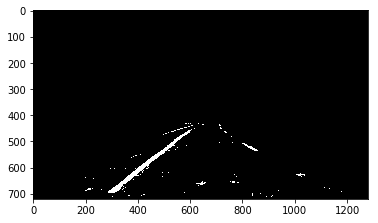

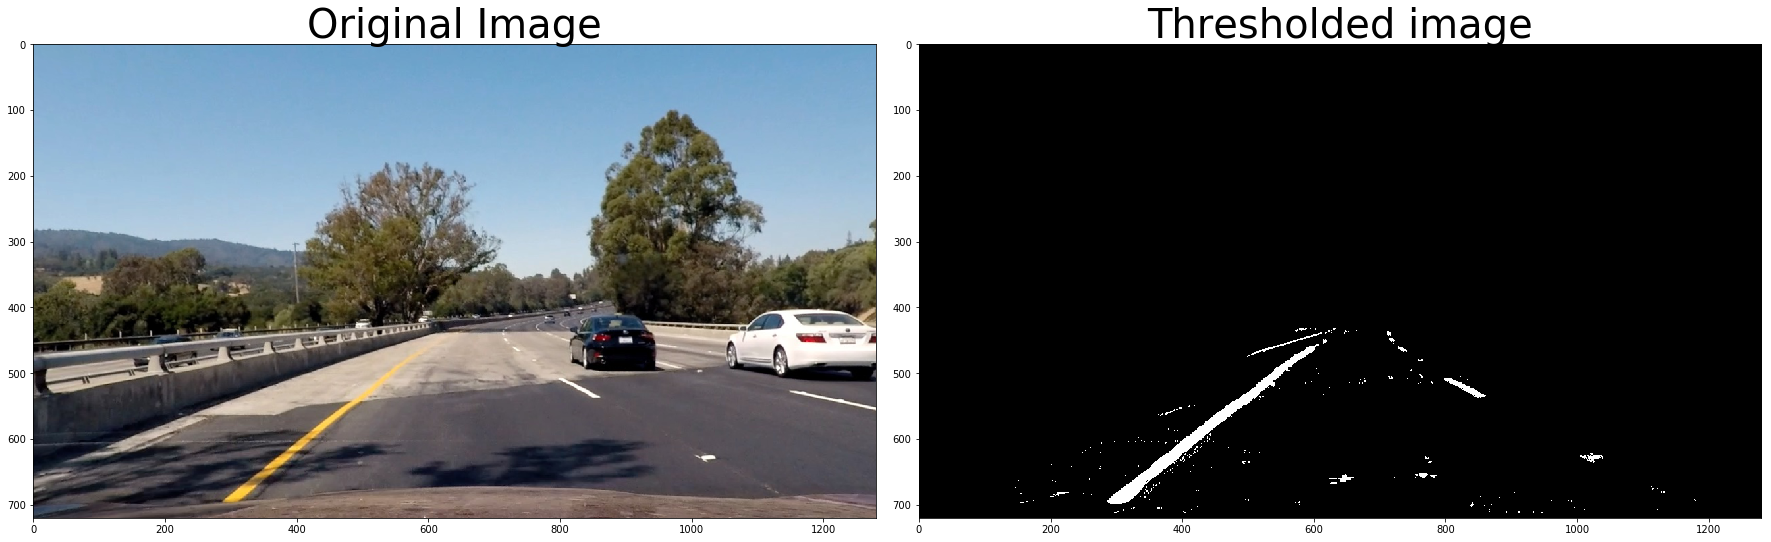

In [6]:
image = image_undistorted   # use undistorted image from last step in pipeline
original_image_undistorted=image_undistorted # for further reference for plotting things


# Edit this function to create your own pipeline.
def thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)): #s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # suggestion 1: color threshold to the B(range:145-200 in LAB for shading & brightness changes 
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    B_channel = lab[:,:,2]
    # suggestion 2: ... and  R in RGB in final pipeline 
    R_channel = img[:,:,0]
    # suggestion 3: And thresholding L (range: 215-255) of Luv for whites.
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L_channel = luv[:,:,0]
    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold B (LAB) channel
    s_B_binary = np.zeros_like(s_channel)
    s_B_binary[(B_channel >= 145) & (B_channel <= 200)] = 1
    
    # Threshold R (RGB) channel
    s_R_binary = np.zeros_like(s_channel)
    s_R_binary[(R_channel >= 145) & (R_channel <= 200)] = 1
    
    # Threshold L (LAB) channel
    s_L_binary = np.zeros_like(s_channel)
    s_L_binary[(L_channel >= 230) & (L_channel <= 255)] = 1 # 215
    
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1 # & sometimes gives better results
    #combined_binary[(s_B_binary == 1)] = 1  # yellow nicely recognized
    #combined_binary[(s_R_binary == 1)] = 1  #yellow nicely recognized, too
    #combined_binary[(s_L_binary == 1)] = 1  # withe nicely recognized
    #  ???combined_binary[(s_B_binary == 1) | (s_L_binary == 1)] = 1 
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (s_B_binary == 1) |  (s_L_binary == 1)] = 1 
    #combined_binary[(s_L_binary == 1)] = 1 
    
    return color_binary, combined_binary  # colour-binary just for plotting purposes
    
result, result_gray_unclipped = thresholding(image)

# aditionally apply mask as in P1
imshape = image.shape
new_vertices = np.array([[(60,int(imshape[0]*0.99)),
                          (imshape[1]*0.45,int(imshape[0]*0.6)),
                          (imshape[1]*0.55,  int(imshape[0]*0.6)), 
                          (imshape[1]-50,int(imshape[0])*0.99)]], dtype=np.int32)
result_gray = region_of_interest(result_gray_unclipped, new_vertices)
    

plt.imshow(result_gray,cmap='gray')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

#ax2.set_title('Combined S channel and gradient thresholds')
#ax2.imshow(combined_binary, cmap='gray')

ax2.imshow(result_gray,cmap='gray')
ax2.set_title('Thresholded image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## 2.3 Apply perspective transform.

(720, 1280)


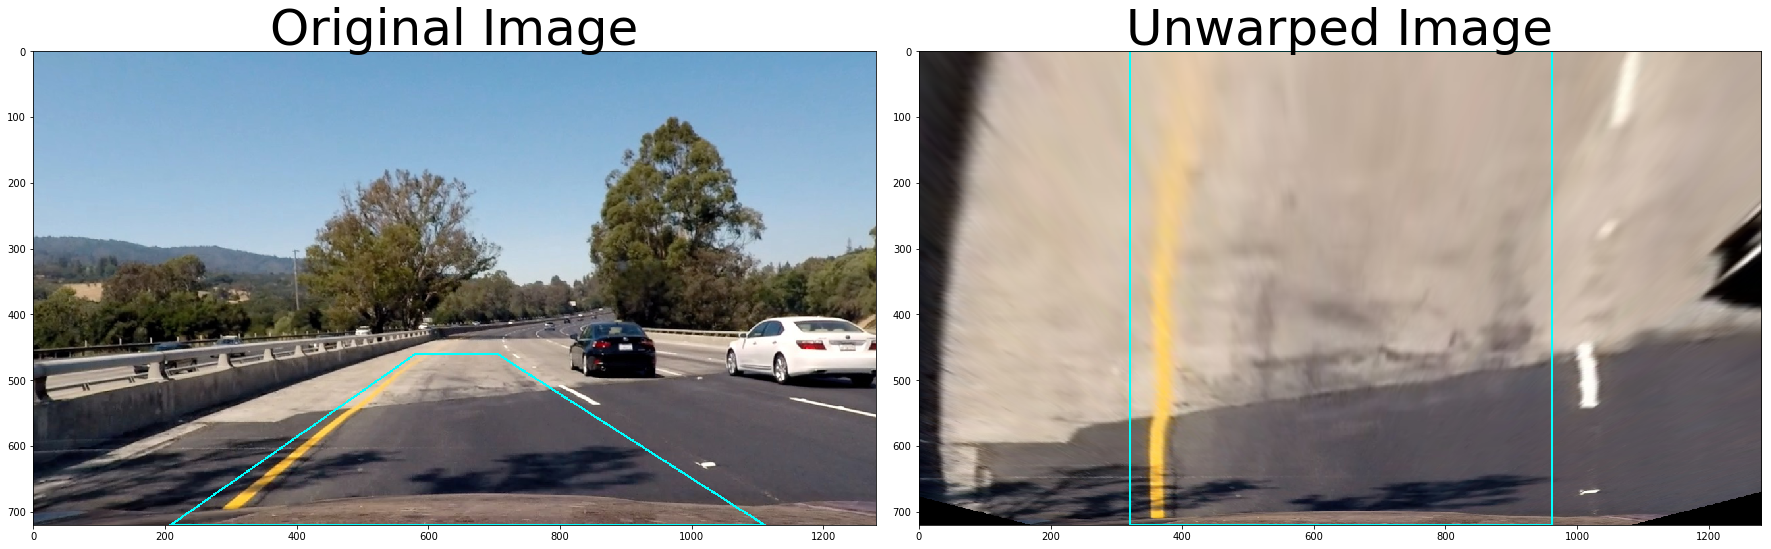

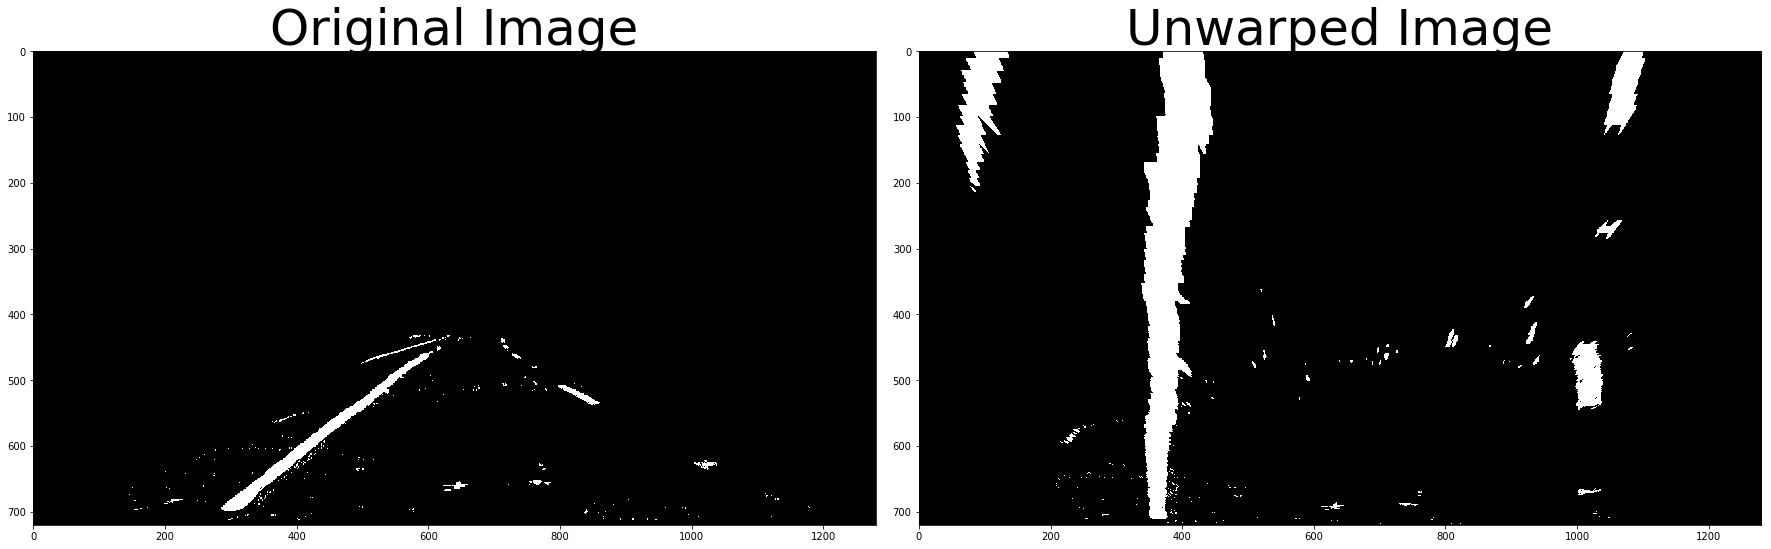

In [7]:
image = result_gray   # use undistorted and thresholded image from last step in pipeline
print(image.shape)


def unwarp(img):
    img_size=(img.shape[1],img.shape[0])
    src = np.float32(
     [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - (5)), img_size[1]],
     [(img_size[0] * 5 / 6) + 45, img_size[1]],
     [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped=cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, src, dst
    
# the following is for the pipeline    
top_down_gray, perspective_M, src, dst = unwarp(result_gray)

#the remainder is only for plotting pictures for the writeup
top_down, perspective_M, src, dst = unwarp(original_image_undistorted)

src = src.reshape((-1,1,2))
orig_plus_polygon=cv2.polylines(original_image_undistorted,np.int32([src]),True,(0,255,255),2)
dst = dst.reshape((-1,1,2))
top_down_plus_polygon=cv2.polylines(top_down,np.int32([dst]),True,(0,255,255),2)

#print(perspective_M.shape)original_image_undistorted
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_plus_polygon)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_plus_polygon)
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#print(perspective_M.shape)original_image_undistorted
#print(top_down.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result_gray,cmap='gray')
#ax1.imshow(image,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_gray,cmap='gray')
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 2.4 Fit lines with polynomial.

In [8]:
# Define a "memory" class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # confidence value 
        self.valid = 1  
        #coeffients of last valid x estimat
        self.best_fit = np.array([0,0,0], dtype='float') 
        #coeffients of freshly computed estimate
        self.best_fit_fresh = np.array([0,0,0], dtype='float') 
        #radius of curvature of the line in metres (will be smoothed by an exponential average)
        self.radius_of_curvature = -500 
        #x values for detected line pixels
        self.allx = np.zeros(720,dtype='float')   
        #y values for detected line pixels
        self.ally = np.zeros(720,dtype='float')     
        #x values for freshly detected line pixels
        self.allx_fresh = np.zeros(720,dtype='float')   
        #y values for freshly detected line pixels
        self.ally_fresh = np.zeros(720,dtype='float')     

In [9]:
lLine=Line()   # initialize Memory objects  #320
lLine.allx = np.full(720, 320)
lLine.allx_fresh=lLine.allx
lLine.best_fit=np.array([-9.05859270e-06, -5.43159140e-03,  3.30359978e+02])   # start off with reasonable values
lLine.best_fit_fresh= lLine.best_fit
rLine=Line()   #940
rLine.allx = np.full(720, 940)
rLine.allx_fresh=rLine.allx
rLine.best_fit= np.array([ 3.48712331e-05 , -3.18104206e-03 , 9.41178462e+02]) # start off with reasonable values
rLine.best_fit_fresh = rLine.best_fit

[ 9.58138431e-05 -1.36372308e-01  4.10408256e+02]
[ 4.39413725e-04 -3.84842459e-01  1.09058689e+03]


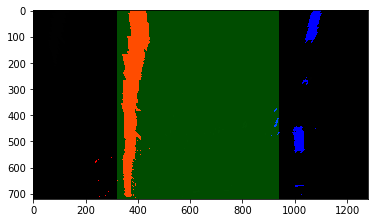

In [10]:
binary_warped = top_down_gray  #use image from last step in pipeline
#print(binary_warped.shape)

def find_lane_pixels_from_scratch(binary_warped): 
    #print("computing from scratch")
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0)  
    # Create an output image to draw on and visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 125  # increased from 100 (classroom quiz)
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ###  Find the four below boundaries of the window ###
        win_xleft_low = leftx_current- margin
        win_xleft_high = leftx_current+ margin   
        win_xright_low = rightx_current- margin   
        win_xright_high = rightx_current+ margin  
        
        # optional: Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ###  Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) 
                          &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) 
                          &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if good_left_inds.size > minpix:
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if good_right_inds.size > minpix:
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
   
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def find_lane_pixels_using_prev(binary_warped):
    
    #print("using prior values!")
    
    left_fit = lLine.best_fit  # using the fresh coefficients seems better!
    right_fit = rLine.best_fit 
    
    def fit_poly(img_shape, leftx, lefty, rightx, righty):
        right_fit = np.polyfit(righty, rightx,2)
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        return left_fitx, right_fitx, ploty
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    #ploty_ = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx_ = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_fitx_ = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    
    #left_fitx_ = lLine.allx
    #right_fitx_ = rLine.allx
    
    
    win_xleft_low = left_fitx_ - margin 
    win_xleft_high = left_fitx_+ margin  
    win_xright_low = right_fitx_ - margin   
    win_xright_high = right_fitx_ + margin  
    left_lane_inds =  ((nonzerox > win_xleft_low)  & (nonzerox < win_xleft_high)).nonzero()[0]
    right_lane_inds = ((nonzerox > win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)


    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    #result = search_around_poly(binary_warped)
    #REMARK better saturate these values .. 
    left_fitx_out =  np.int32(np.maximum(np.minimum(left_fitx, 1279),0 ))
    right_fitx_out =  np.int32(np.maximum(np.minimum(right_fitx, 1279),0 ))
    return left_fitx_out, np.int32(ploty) , right_fitx_out , np.int32(ploty) #leftx, lefty, rightx, righty


def fit_polynomial(binary_warped):
    
    # depending on confidence values ("valid" is an integer score here, not merely a flag)
    # NOTE: "from prior" has been turned OFF here, as it seems to be better. Doubts remain. 
    if  True or (not ((lLine.valid) >0 and (rLine.valid>0))):   # it seems better to always compute from scratch, presently
        #print("not both lines valid!")
        leftx, lefty, rightx, righty = find_lane_pixels_from_scratch(binary_warped)
    else: 
        leftx, lefty, rightx, righty = find_lane_pixels_using_prev(binary_warped)
        
        

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx,2)
    lLine.best_fit_fresh =left_fit# #store values for plausibility check later on
    right_fit = np.polyfit(righty, rightx,2)
    rLine.best_fit_fresh =right_fit 

                                
    
    # Generate x and y values for plotting
    ploty = np.int32(np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )) 
    left_fitx = np.int32(left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
    left_fitx = np.minimum(left_fitx, 1279) 
    left_fitx = np.maximum(left_fitx, 0) 
    right_fitx = np.int32(right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])
    right_fitx = np.minimum(right_fitx, 1279) 
    right_fitx = np.maximum(right_fitx, 0) 
    
    lLine.allx_fresh =left_fitx 
    rLine.allx_fresh =right_fitx #store values for plausibility check later on
  
    
        
   
   
    
    ## Visualization ## plot last valid value!
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255
    # Colors in the left and right lane regions
    
    # using previously stored, valid values!
    left_fitxv = np.int32(lLine.allx)#left_fitx # np.int32(lLine.allx)
    left_fitxv = np.minimum(left_fitxv, 1279) 
    left_fitxv = np.maximum(left_fitxv, 0) 
    right_fitxv = np.int32(rLine.allx) #right_fitx #np.int32(rLine.allx)
    right_fitxv = np.minimum(right_fitxv, 1279) 
    right_fitxv = np.maximum(right_fitxv, 0) 
    
    
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    out_img[ploty, left_fitxv] = [0, 255, 0]
    out_img[ploty, right_fitxv] = [0, 255, 0]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow',linewidth=4.0)
    #plt.plot(right_fitx, ploty, color='yellow',linewidth=4.0)
    
    
    # Draw the lane onto the  image
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped)) *255
    window_img = np.zeros_like(out_img)
    
    #optional, more colorful plotting:
    #margin=np.int32(10)
    #
    #left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    #left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
    #                          ploty])))])
    #left_line_pts = np.hstack((left_line_window1, left_line_window2))
    #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
    #                          ploty])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))
    #cv2.fillPoly(window_img, np.int32([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int32([right_line_pts]), (0,255, 0))
    
    green_stripe_window1 = np.array([np.transpose(np.vstack([left_fitxv, ploty]))])
    green_stripe_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitxv, 
                              ploty])))])
    green_stripe_pts = np.hstack((green_stripe_window1, green_stripe_window2))
    cv2.fillPoly(window_img, np.int32([green_stripe_pts]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result,ploty,left_fitx,right_fitx ,left_fit,right_fit


out_img, ploty,left_fitx_fresh,right_fitx_fresh, left_fit,right_fit = fit_polynomial(binary_warped)#
#lLine.allx = lLine.allx_fresh
#rLine.allx = lLine.allx_fresh
#lLine.best_fit =lLine.best_fit_fresh
#rLine.best_fit =rLine.best_fit_fresh
#out_img, ploty,left_fitx_fresh,right_fitx_fresh, left_fit,right_fit = fit_polynomial(binary_warped) # twice due to init

plt.imshow(out_img)

print(left_fit)
print(right_fit)


## 2.5 Compute curvature and offset in metres.

In [11]:
def plausibility_check(ploty_cr, left_fitx_cr, right_fitx_cr,left_fit,right_fit,left_curverad, 
                       right_curverad, offset_x_m):
    ''' here we check the computed coefficients for plausibility and update lLine.best_fit and lLine.allx 
    accordingly. (using an exponential moving average, PT1-filter, convex combination between old and new)
    the update is done as a side effect. We know this is not good style. 
    most values ar in metres _cr, but left_fit and right_fit ar in pixels ... '''
    #check if the lines are roughly parallel 
    mindistance= np.min(right_fitx_cr- left_fitx_cr) # at least 3m typ. value: 3.35317400005
    maxdistance=np.max((right_fitx_cr- left_fitx_cr)) # no more than 4m typ. value: 3.61941697379
    meandistance= np.mean(right_fitx_cr- left_fitx_cr) 
    #print(meandistance)
    #distance_ok= (mindistance > 2.9) and (maxdistance <3.6)
    distance_ok= (meandistance > 3) and (meandistance <3.5)
    #check if curverads are consistent (i.e. they have the same sign and roughly the same magnitude, except in special cases)
    curverads_ok= False
    if np.abs(left_curverad) > 1e4 and np.abs(right_curverad) > 1e4:
        curverads_ok = True
    elif np.abs(left_curverad) < 20 or  np.abs(right_curverad) < 20:
        curverads_ok = False
    elif 0.3 < left_curverad/right_curverad and  left_curverad/right_curverad  < 1/0.3:  # close enough
        curverads_ok = True
    else: 
        curverads_ok = False
    # are the bottoms of thelanes in the right place?
    leftbottx=left_fitx_cr[-1]+offset_x_m # more than 1.6m
    rightbottx=right_fitx_cr[-1]+offset_x_m  #no more than 5.1m
    
    alpha=0.5 # coefficient/hyperparameter for exponential moving average
    isplausible_left=distance_ok  and curverads_ok # and leftbottx >1.6 # are all criteria satisfied?
    if isplausible_left:  # if yes update lLine / rLine 
        lLine.valid=np.minimum(lLine.valid +1,30) # increase confidence value
        lLine.radius_of_curvature= 1/(1/lLine.radius_of_curvature*(1-alpha)+ 1/left_curverad*alpha)
        # exponential moving average for *curvatures*
        lLine.best_fit= (1-alpha)*lLine.best_fit + alpha*lLine.best_fit_fresh  # exponential moving av for coefficients (pixels)
        lLine.allx =  np.int32((1-alpha)*lLine.allx+alpha*lLine.allx_fresh) #left_fitx_cr/(3.7/700)) # exponential moving av x-vals (pixels)
        #print(left_fitx_fresh[21])
        lLine.ally = np.int32(ploty_cr/(30/720 ))
    else: # otherwise keep old values and mark invalid
        #print("not plausible left")
        #keep previous values and
        #print("curverads_ok " + str(curverads_ok))
        #print("  left_curverad  " + str(left_curverad))
        #print("  right_curverad  " + str(right_curverad))
        #print("distance_ok " + str(distance_ok))
        #print("  mindistance (> 2.7)" + str(mindistance))
        #print("  maxdistance (< 3.6)" + str(maxdistance))
        #print("leftbottx (>1.6) " + str(leftbottx))
        #print("rightbottx (<5.1) " + str(rightbottx))
        lLine.valid=0 #=np.maximum(lLine.valid -1,0) # decrease confidence value
        
    isplausible_right=distance_ok  and curverads_ok #and rightbottx < 5.1 # are all criteria satisfied?
    if isplausible_right:  # if yes update lLine / rLine     
        rLine.valid=np.minimum(rLine.valid +1,30)
        rLine.radius_of_curvature= 1/(1/rLine.radius_of_curvature*(1-alpha)+ 1/right_curverad*alpha)
        # exponential moving average for *curvatures*
        rLine.best_fit= (1-alpha)*rLine.best_fit + alpha*rLine.best_fit_fresh  # exponential moving av for coefficients 
        rLine.allx =  np.int32((1-alpha)*rLine.allx+alpha*rLine.allx_fresh) #right_fitx_cr/(3.7/700)) #np.int32(right_fitx_cr/(3.7/700))
        rLine.ally = np.int32(ploty_cr/(30/720 ))# np.int32(ploty_cr/(30/720 ))
    else: # otherwise keep old values and mark invalid
        #print("not plausible right")
        #keep previous values and
        #print("right inconsistent")
        rLine.valid=0 #=np.maximum(rLine.valid -1,0) # decrease confidence value
    
    return isplausible_left, isplausible_right # return values not strictly required, side effect ... 


def convert_to_metres(ploty, left_fit,right_fit , ym_per_pix, xm_per_pix):
    '''
    converts/rescales all coefficients etc. to metres
    '''
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty*ym_per_pix, rightx*xm_per_pix, leftx*xm_per_pix,left_fit_cr, right_fit_cr

    
def measure_curvature_and_offset_real(ploty, left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    implicitely does the plausibility checks and the update of the "memory-objects". Messy. 
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty_cr, rightx_cr, leftx_cr, left_fitx_cr, right_fitx_cr = convert_to_metres(ploty, 
                    left_fit,right_fit,ym_per_pix, xm_per_pix)
    #return ploty*ym_per_pix, rightx*xm_per_pix, leftx*xm_per_pix,left_fit_cr, right_fit_cr
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty_cr)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    A=left_fitx_cr[0]
    B=left_fitx_cr[1]
    left_curverad = 1/(2*A)* (1+(2*A*y_eval+B)**2)**(3/2) 
    A=right_fitx_cr[0]
    B=right_fitx_cr[1]
    right_curverad = 1/(2*A)* (1+(2*A*y_eval+B)**2)**(3/2)   
    #compute offset 
    leftx_bot = left_fitx_cr[0]*y_eval**2 + left_fitx_cr[1]*y_eval + left_fitx_cr[2]
    rightx_bot = right_fitx_cr[0]*y_eval**2 + right_fitx_cr[1]*y_eval + right_fitx_cr[2]
    avx_bot=1/2*(leftx_bot +rightx_bot)
    offset_x_m= 1280/2*xm_per_pix -avx_bot
    
    # now perform plausibility check and update of "memory objects" in this hidden place
    plausibility_check(ploty_cr, leftx_cr, rightx_cr,left_fit,right_fit,left_curverad, right_curverad, offset_x_m)
    
    return left_curverad, right_curverad,offset_x_m

#Now perform the step in the pipeline: 
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, offset_x_m = measure_curvature_and_offset_real(ploty, left_fit,right_fit )


print(left_curverad, 'm', right_curverad, 'm', offset_x_m, 'm')


1714.7883057113866 m 375.07750071130226 m -0.584058595391276 m


## 2.6 Projecting back to the road.

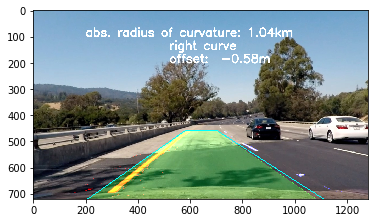

In [12]:
def warp_again(img):
    img_size=(img.shape[1],img.shape[0])
    src = np.float32(                                   #hand coded, fitted by hand on test images
     [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - (5)), img_size[1]],
     [(img_size[0] * 5 / 6) + 45, img_size[1]],
     [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
    # use cv2.geimage_undistortedtPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform( dst,src) # other way round!! back-transform
    warped=cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, src, dst
def project_back(img, curverad,offset_x_m):
    warped_again, M, src, dst = warp_again(img)
    #finalpic = cv2.addWeighted(image_undistorted, 1, warped_again, 0.9, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    if np.abs(curverad) >6000:
        string1= 'radius of curvature: > 6km'
        string3= 'going straight'
    else:
        string1= 'abs. radius of curvature: '+str(np.abs(round(curverad/1000,2)))+'km'
        if curverad > 0:
            string3='right curve'
        else:
            string3='left curve'                                        
    string2='offset:  '+str(round(offset_x_m,2))+'m'
    cv2.putText(warped_again,string1,(200,100), font, 1.5,(255,255,255),4,cv2.LINE_AA)
    cv2.putText(warped_again,string3,(520,150), font, 1.5,(255,255,255),4,cv2.LINE_AA)
    cv2.putText(warped_again,string2,(520,200), font, 1.5,(255,255,255),4,cv2.LINE_AA)
    return warped_again
curverad_av=1/2*(left_curverad+ right_curverad)
warped_again=project_back(out_img,curverad_av,offset_x_m )

finalpic = cv2.addWeighted(image_undistorted, 1, warped_again, 0.9, 0)
plt.imshow(finalpic)

# 3 Pipeline video

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


dist_pickle = pickle.load( open( "./camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

framenb=0 


In [14]:
def process_image(image):
    #global framenb
    #framenb = framenb+1
    #if framenb==1055:
    #    #cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # cv2.imwrite('difficult_picture.jpg', image)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #2.1
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    #2.2
    result, result_gray = thresholding(image_undistorted)
    
    #2.3  # here I inserted an additional clipping like in project P1
    imshape = image.shape
    new_vertices = np.array([[(60,int(imshape[0]*0.99)),(imshape[1]*0.45,  int(imshape[0]*0.6)), (imshape[1]*0.55,  int(imshape[0]*0.6)), \
                      (imshape[1]-50,int(imshape[0])*0.99)]], dtype=np.int32)
    masked_line_image = region_of_interest(result_gray, new_vertices)
    #this is the actual step 2.3:
    top_down_gray, perspective_M, src, dst = unwarp(masked_line_image)
    
    #2.4
    #out_img, ploty,left_fitx,right_fitx, left_fit,right_fit = fit_polynomial(top_down_gray)
    out_img, ploty,left_fitx_fresh,right_fitx_fresh, left_fit,right_fit = fit_polynomial(top_down_gray)

    
    #2.5
    left_curverad, right_curverad, offset_x_m = measure_curvature_and_offset_real(ploty, left_fit,right_fit )
    # note that a plausibiliy check is performed inside this functions and the "memory"-objects lLine and rLine
    #are updated accordingly

    #2.6
    #warped_again=project_back(out_img,left_curverad, right_curverad,offset_x_m )
    curverad_av=1/2*(lLine.radius_of_curvature +rLine.radius_of_curvature)
    warped_again=project_back(out_img,curverad_av,offset_x_m )

    finalpic = cv2.addWeighted(image_undistorted, 1, warped_again, 0.9, 0)
    
    exit()
    #  lines_edges = weighted_img( masked_line_image,image)   
    #out_image_gray= result_gray
    #out_img = np.dstack((out_image_gray, out_image_gray, out_image_gray))
    return finalpic#out_img #image

In [15]:
lLine=Line()   # initialize Memory objects  #320
lLine.allx = np.full(720, 320)
lLine.allx_fresh=lLine.allx
lLine.best_fit=np.array([-9.05859270e-06, -5.43159140e-03,  3.30359978e+02])   # start off with reasonable values
lLine.best_fit_fresh= lLine.best_fit
rLine=Line()   #940
rLine.allx = np.full(720, 940)
rLine.allx_fresh=rLine.allx
rLine.best_fit= np.array([ 3.48712331e-05 , -3.18104206e-03 , 9.41178462e+02]) # start off with reasonable values
rLine.best_fit_fresh = rLine.best_fit


prev_line_image=np.zeros((540, 960, 3), dtype=np.uint8)
output_video_name = 'output_project_video.mp4'
input_clip = VideoFileClip("project_video.mp4")#.subclip(0,5)
output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video_name, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [02:04<00:00, 10.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 11min 11s, sys: 6.93 s, total: 11min 18s
Wall time: 2min 5s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name))


In [17]:
lLine=Line()   # initialize Memory objects  #320
lLine.allx = np.full(720, 320)
lLine.allx_fresh=lLine.allx
lLine.best_fit=np.array([-9.05859270e-06, -5.43159140e-03,  3.30359978e+02])   # start off with reasonable values
lLine.best_fit_fresh= lLine.best_fit
rLine=Line()   #940
rLine.allx = np.full(720, 940)
rLine.allx_fresh=rLine.allx
rLine.best_fit= np.array([ 3.48712331e-05 , -3.18104206e-03 , 9.41178462e+02]) # start off with reasonable values
rLine.best_fit_fresh = rLine.best_fit


prev_line_image=np.zeros((540, 960, 3), dtype=np.uint8)
output_video_name = 'output_challenge_video_v2.mp4'
input_clip = VideoFileClip("challenge_video.mp4")#.subclip(0,5)
output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video_name, audio=False)

[MoviePy] >>>> Building video output_challenge_video_v2.mp4
[MoviePy] Writing video output_challenge_video_v2.mp4


100%|██████████| 485/485 [00:51<00:00,  9.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video_v2.mp4 

CPU times: user 4min 28s, sys: 3.33 s, total: 4min 31s
Wall time: 52.1 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name))

In [19]:
lLine=Line()   # initialize Memory objects  #320
lLine.allx = np.full(720, 320)
lLine.allx_fresh=lLine.allx
lLine.best_fit=np.array([-9.05859270e-06, -5.43159140e-03,  3.30359978e+02])   # start off with reasonable values
lLine.best_fit_fresh= lLine.best_fit
rLine=Line()   #940
rLine.allx = np.full(720, 940)
rLine.allx_fresh=rLine.allx
rLine.best_fit= np.array([ 3.48712331e-05 , -3.18104206e-03 , 9.41178462e+02]) # start off with reasonable values
rLine.best_fit_fresh = rLine.best_fit


prev_line_image=np.zeros((540, 960, 3), dtype=np.uint8)
output_video_name = 'output_harder_challenge_video.mp4'
input_clip = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,5)
output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video_name, audio=False)

[MoviePy] >>>> Building video output_harder_challenge_video.mp4
[MoviePy] Writing video output_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [02:38<00:00,  7.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge_video.mp4 

CPU times: user 12min 31s, sys: 6.36 s, total: 12min 38s
Wall time: 2min 39s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name))